In [1]:
!pip install nltk pandas numpy scikit-learn numpy wordcloud[speedup]

import pandas as pd
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import sys
import nltk
import random
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from textblob import TextBlob

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Mount Google Drive to access the dataset files
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Functions needed for the code

# function to remove stop words
def remove_stop_words(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# function to tokenize and lemmatize text
def clean_review_text(text):
    tokenz = word_tokenize(text)
    tokenz = [lemmatizer.lemmatize(token.lower()) for token in tokenz if token.isalpha() and token.lower() not in stop_words]
    return ' '.join(tokenz)

# define a function to perform sentiment analysis
def get_sentiment(text):
    if isinstance(text, float):  # handle missing or null values
        return 0.0  # set sentiment to 0.0
    blob = TextBlob(text)
    return blob.sentiment.polarity

In [3]:
# load the dataset
merged_df = pd.read_csv('/content/drive/My Drive/combined_final_data.csv')

# replace missing or null values with an empty string
merged_df['amazon_review_body'].fillna('', inplace=True)
merged_df['walmart_review_body'].fillna('', inplace=True)

# apply the sentiment analysis function to the review body column
merged_df['sentiment'] = merged_df['amazon_review_body'].apply(get_sentiment) + merged_df['walmart_review_body'].apply(get_sentiment)

# print the dataframe head
print(merged_df.head(10))

                                       product_title  amazon_star_rating  \
0  The Cravings Place Chocolate Chunk Cookie Mix,...                   5   
1            Mauna Loa Macadamias, 11 Ounce Packages                   5   
2  Organic Matcha Green Tea Powder - 100% Pure Ma...                   5   
3  15oz Raspberry Lyons Designer Dessert Syrup Sauce                   5   
4  Stride Spark Kinetic Fruit Sugar Free Gum, 14-...                   5   
5        Herr's Popcorn Hot Cheese 1 Oz (Pack of 30)                   2   
6              Larabar uber, 1.42 Ounce (Pack of 15)                   5   
7                 Shirakiku Soba Noodles, 7.16 Ounce                   5   
8  Jif Chocolate Nut Butter Almond Granola Bars, ...                   5   
9  Orgain Organic Plant Based Protein Powder, Pac...                   1   

   amazon_total_votes                                 amazon_review_body  \
0                   0  family allergic wheat dairy eggs nuts several ...   
1          

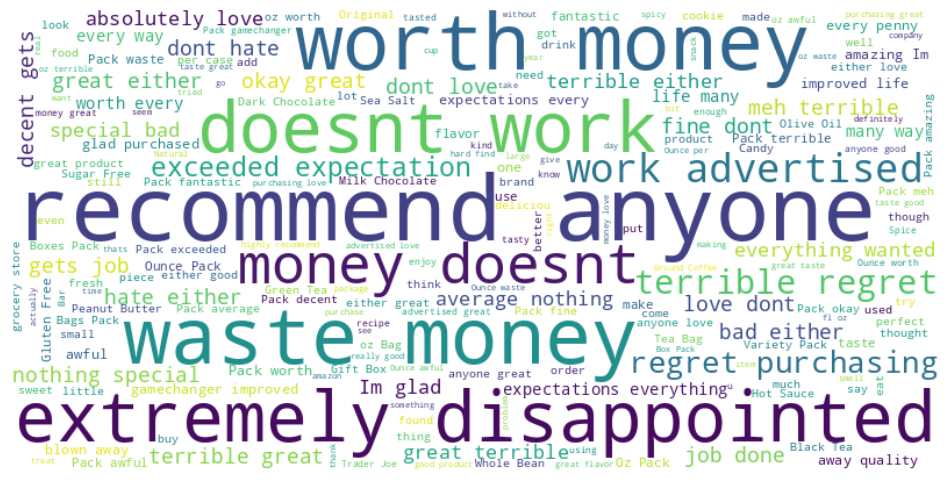

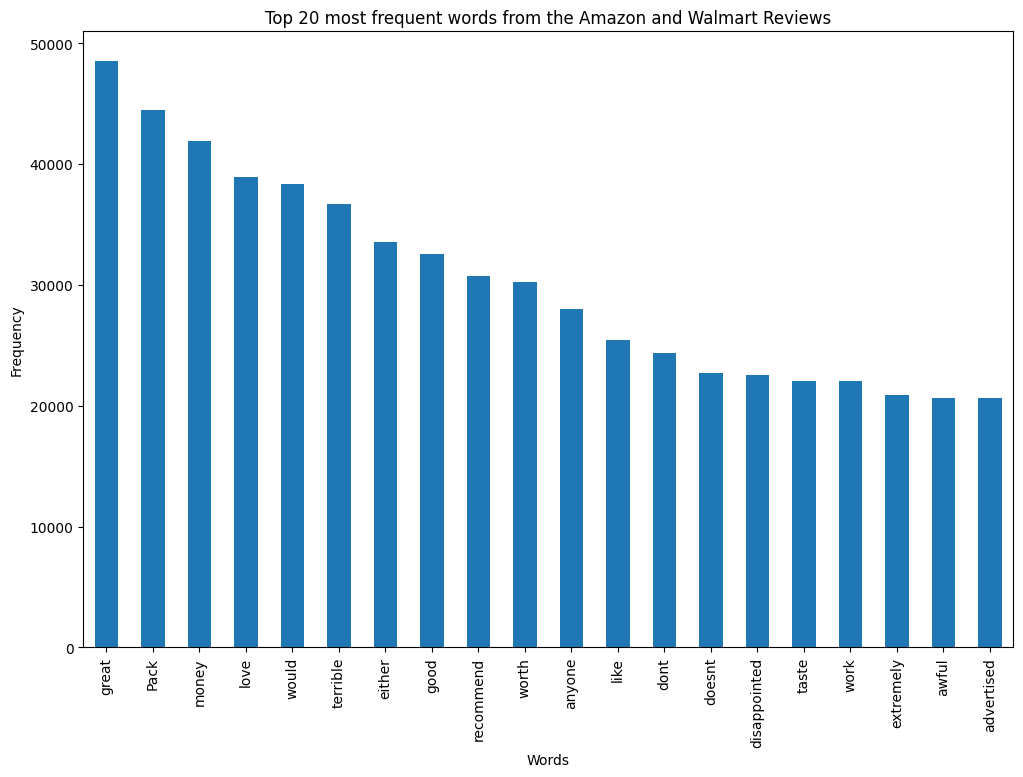

In [4]:
# Merging amazon and walmart reviews into one column and cleaning it of stopwords for further analysis
merged_df['cleaned_review_body'] = merged_df['amazon_review_body'] + ' ' + merged_df['walmart_review_body']

# Define the regular expression pattern to match special characters
pattern = r'[^a-zA-Z0-9\s]'

# Remove special characters from the merged_review_body column
merged_df['cleaned_review_body'] = merged_df['cleaned_review_body'].apply(lambda x: re.sub(pattern, '', x))

# Removing stopwords
merged_df['cleaned_review_body'] = merged_df['cleaned_review_body'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

# Define the text data
text_data = ' '.join(merged_df['cleaned_review_body'].astype(str))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
print("\n")

# Generate the bar chart
word_counts = pd.Series(text_data.split()).value_counts()[:20]
plt.figure(figsize=(12, 8))
word_counts.plot(kind='bar')
plt.title('Top 20 most frequent words from the Amazon and Walmart Reviews')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

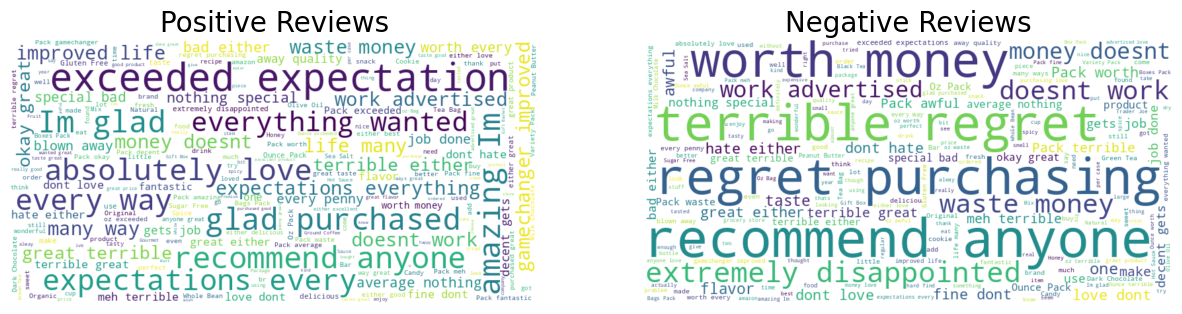

In [5]:
# Wordclouds for positive and negative keywords

# Create separate dataframes for positive and negative reviews
positive_df = merged_df[merged_df['sentiment'] > 0.5]
negative_df = merged_df[merged_df['sentiment'] < 0.5]

# Combine all the reviews into a single string for each dataframe
positive_text = " ".join(review for review in positive_df['cleaned_review_body'])
negative_text = " ".join(review for review in negative_df['cleaned_review_body'])

# Generate wordclouds for positive and negative reviews
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

# Plot the wordclouds
fig, axs = plt.subplots(1, 2, figsize=(15, 7.5))
axs[0].imshow(positive_wordcloud, interpolation='bilinear')
axs[0].set_title('Positive Reviews', fontsize=20)
axs[0].axis('off')
axs[1].imshow(negative_wordcloud, interpolation='bilinear')
axs[1].set_title('Negative Reviews', fontsize=20)
axs[1].axis('off')
plt.show()

Classification Report for Sentiment Analysis:               precision    recall  f1-score   support

           0       0.93      0.97      0.95     43743
           1       0.58      0.34      0.43      5074

    accuracy                           0.91     48817
   macro avg       0.75      0.65      0.69     48817
weighted avg       0.89      0.91      0.89     48817



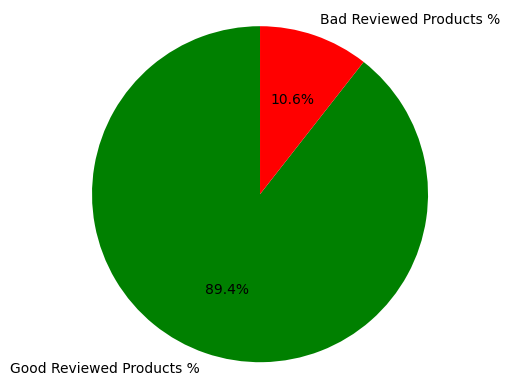

In [6]:
# Bad Review finder using Naive Bayes Classifier ML Model based on star_rating
# Cleaning text
merged_df['cleaned_review_body'] = merged_df['cleaned_review_body'].apply(clean_review_text)

# Generating average_star_rating based on both Amazon and Walmart Ratings
merged_df['star_rating'] = (merged_df['amazon_star_rating'] + merged_df['walmart_star_rating']) / 2

# defining good/bad products based on star_rating
merged_df['is_bad_product'] = merged_df['star_rating'].apply(lambda x: 1 if x < 2.5 else 0)

# vectorize cleaned_review_body
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(merged_df['cleaned_review_body'])
y = merged_df['is_bad_product']

# splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# training Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# prediction on test dataset
y_pred = nb_classifier.predict(X_test)

# Classification report
print("Classification Report for Sentiment Analysis:", classification_report(y_test, y_pred))

good_count = len(merged_df[merged_df['is_bad_product'] == 0])
bad_count = len(merged_df[merged_df['is_bad_product'] == 1])

# Visualize the percentage of Good vs Bad product reviews
labels = ['Good Reviewed Products %', 'Bad Reviewed Products %']
sizes = [good_count, bad_count]
colors = ['green', 'red']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.show()
print("\n")

Percentage of profane reviews: 17.765882916876635%
Percentage of non-profane reviews: 82.23411708312337%


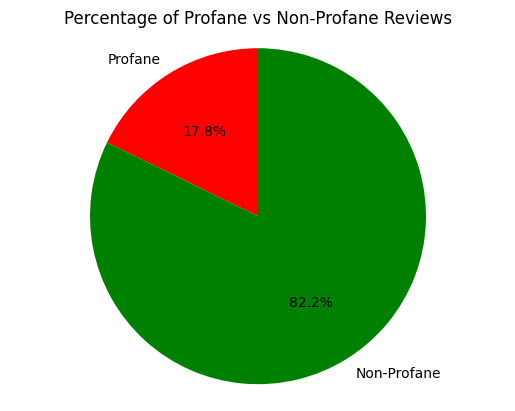

In [7]:
# Profanity Checker
import requests
url = 'https://raw.githubusercontent.com/snguyenthanh/better_profanity/0.7.0/better_profanity/profanity_wordlist.txt'
response = requests.get(url)
profane_words_1 = response.content.decode('utf-8').split('\n')

another_url = 'https://www.cs.cmu.edu/~biglou/resources/bad-words.txt'
response = requests.get(another_url)
profane_words_2 = response.content.decode('utf-8').split('\n')

# Removing duplicates and merging profanity words data
profane_words = list(set(profane_words_1 + profane_words_2))

# Function to check profanity
def check_profanity(text):
    text_words = text.split()
    profanity_count = 0
    for word in text_words:
        if word.lower() in profane_words:
            profanity_count += 1
    if profanity_count > 0:
        return True
    else:
        return False

# Set threshold for profanity score
threshold = 0.5

# Check for profanity in each review
profanity_scores = []
for review in merged_df['cleaned_review_body']:
    # Split review into individual words
    scores = check_profanity(review)
    # Calculate average profanity score for review
    avg_score = np.mean(scores)
    # Check if average score is above threshold
    if avg_score > threshold:
        profanity_scores.append(1)
    else:
        profanity_scores.append(0)

# Add profanity scores as a new column in the dataframe
merged_df['profanity_score'] = profanity_scores

# Visualize the percentage of profane vs non-profane reviews
profane_count = len(merged_df[merged_df['profanity_score'] == 1])
non_profane_count = len(merged_df[merged_df['profanity_score'] == 0])
print(f"Percentage of profane reviews: {profane_count/len(merged_df)*100}%")
print(f"Percentage of non-profane reviews: {non_profane_count/len(merged_df)*100}%")

labels = ['Profane', 'Non-Profane']
sizes = [profane_count, non_profane_count]
colors = ['red', 'green']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Percentage of Profane vs Non-Profane Reviews')
plt.show()

In [8]:
# Total Votes and Star Rating Analysis

# Calculating statistics for Amazon Total Votes and Star Rating
amazon_stats = merged_df[['amazon_star_rating', 'amazon_total_votes']].describe()

# Calculateing statistics for Walmart Total Votes and Star Rating
walmart_stats = merged_df[['walmart_star_rating', 'walmart_total_votes']].describe()

# Printing the stats
print("Amazon statistics:\n", amazon_stats)
print("\nWalmart statistics:\n", walmart_stats)

# Calculating correlation between Amazon and Walmart star ratings
corr = merged_df[['amazon_star_rating', 'walmart_star_rating']].corr()

# Printing the correlation matrix
print("Correlation Matrix:\n", corr)

# Calculating skewness and kurtosis for Amazon and Walmart star ratings
skewness = merged_df[['amazon_star_rating', 'walmart_star_rating']].skew()
kurtosis = merged_df[['amazon_star_rating', 'walmart_star_rating']].kurt()

# Printing the skewness and kurtosis values
print("Skewness:\n", skewness)
print("\nKurtosis:\n", kurtosis)

Amazon statistics:
        amazon_star_rating  amazon_total_votes
count       162722.000000       162722.000000
mean             4.256732            0.699438
std              1.303178            2.603444
min              1.000000            0.000000
25%              4.000000            0.000000
50%              5.000000            0.000000
75%              5.000000            1.000000
max              5.000000          360.000000

Walmart statistics:
        walmart_star_rating  walmart_total_votes
count        162722.000000        162722.000000
mean              2.999370           100.962335
std               1.155578            57.438828
min               1.000000             2.000000
25%               2.000000            51.000000
50%               3.000000           101.000000
75%               4.000000           151.000000
max               5.000000           200.000000
Correlation Matrix:
                      amazon_star_rating  walmart_star_rating
amazon_star_rating            

In [9]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve

# creating the target variable
merged_df["preferred_platform"] = (merged_df["amazon_total_votes"] > merged_df["walmart_total_votes"]).astype(int)

# Defining the features and target variables
X = merged_df[['amazon_star_rating', 'amazon_total_votes', 'walmart_star_rating', 'walmart_total_votes']]
y = merged_df['preferred_platform']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# creating the logistic regression model
lr_model = LogisticRegression()

# defining the parameter grid for logistic regression
lr_param_grid = {
    "penalty": ["l1", "l2"],
    "C": [0.01],
    "solver": ["liblinear", "saga"]
}

# performing grid search for logistic regression
lr_grid_search = GridSearchCV(lr_model, lr_param_grid, cv=5)
lr_grid_search.fit(X_train, y_train)

# getting the best logistic regression model
lr_model = lr_grid_search.best_estimator_

# creating the random forest model
rf_model = RandomForestClassifier()

# defining the parameter grid for random forest
rf_param_grid = {
    "n_estimators": [1, 2],
    "max_depth": [None, 2],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

# performing grid search for random forest
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5)
rf_grid_search.fit(X_train, y_train)

# getting the best random forest model
rf_model = rf_grid_search.best_estimator_

# evaluating the models using cross-validation
lr_scores = cross_val_score(lr_model, X_train, y_train, cv=5)
rf_scores = cross_val_score(rf_model, X_train, y_train, cv=5)

# printing the cross-validation scores
print("Logistic Regression CV Scores:", lr_scores)
print("Random Forest CV Scores:", rf_scores)

# fitting the best model on the entire training set
if lr_scores.mean() > rf_scores.mean():
    best_model = lr_model
    print("Best Model: Logistic Regression")
else:
    best_model = rf_model
    print("Best Model: Random Forest")

best_model.fit(X_train, y_train)

# making predictions on the test set
y_pred = best_model.predict(X_test)

# printing the evaluation metrics on the test set
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Logistic Regression CV Scores: [0.99982442 0.99964883 0.99947325 0.99964883 0.99951714]
Random Forest CV Scores: [0.99938545 0.99960493 0.99925376 0.99907818 0.99960493]
Best Model: Logistic Regression
Accuracy: 0.9994469139848823
Precision: 1.0
Recall: 0.6666666666666666
F1 Score: 0.8


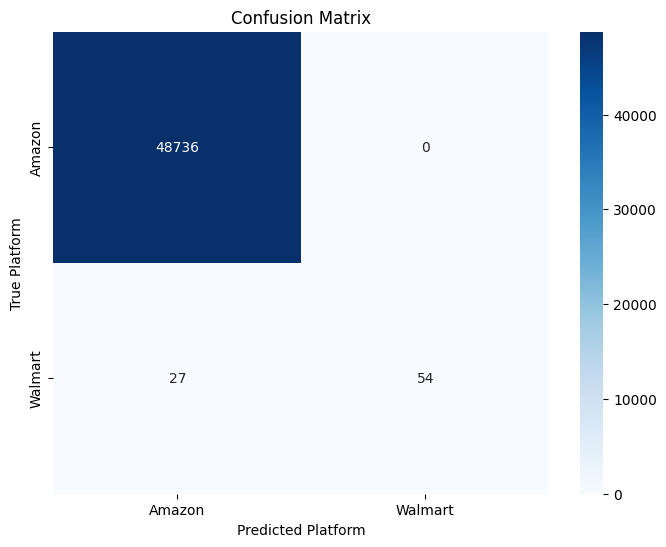

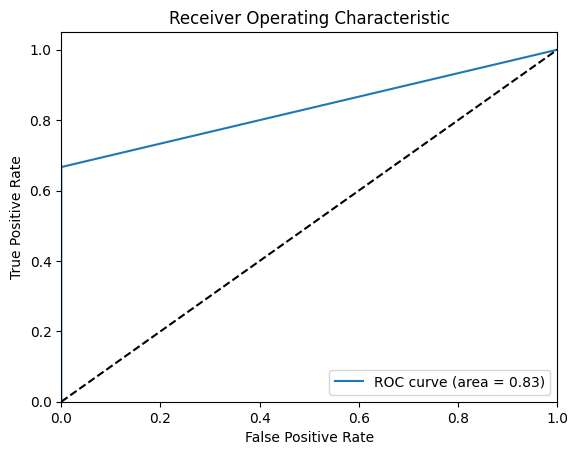

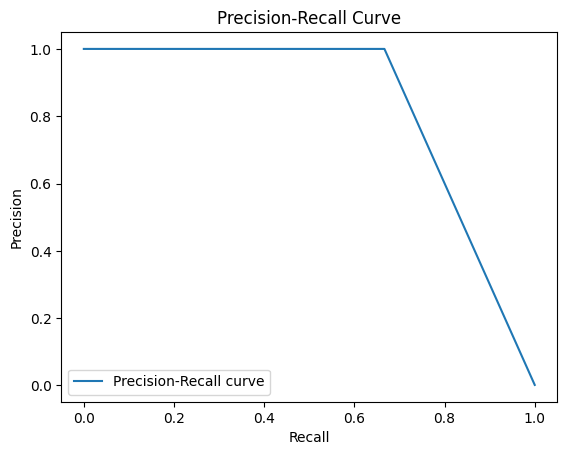

In [10]:
# Getting the predicted probabilities from the best model into a new variable
y_pred_proba = best_model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
classes = ['Amazon', 'Walmart']

# Create a heatmap of the confusion matrix
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes, ax=ax)
ax.set_xlabel('Predicted Platform')
ax.set_ylabel('True Platform')
ax.set_title('Confusion Matrix')
plt.show()
print("\n")

# Create precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Creating ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculating AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)

# Visualizing ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
print("\n")

# Visualizing precision-recall curve
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

In [11]:
# Testing our best model 
input_data = [[4.5, 100, 3.8, 80]]  # example input data

recommendation = "Amazon" if best_model.predict(input_data) else "Walmart"
print("Recommendation:", recommendation)

Recommendation: Amazon


In [12]:
# Function to get sentiment polarity score for review
def get_review_sentiment(review):
    blob = TextBlob(review)
    sentiment_score = blob.sentiment.polarity
    return sentiment_score

# Adding sentiment polarity score columns for Amazon and Walmart ratings
merged_df['amazon_sentiment_score'] = merged_df['amazon_review_body'].apply(get_review_sentiment)
merged_df['walmart_sentiment_score'] = merged_df['walmart_review_body'].apply(get_review_sentiment)

# Function to recommend a platform based on sentiment scores
def recommend_platform(row):
    if row['amazon_sentiment_score'] >= row['walmart_sentiment_score']:
        return 'Amazon'
    else:
        return 'Walmart'

# Add recommended platform column to dataframe
merged_df['recommended_platform'] = merged_df.apply(recommend_platform, axis=1)

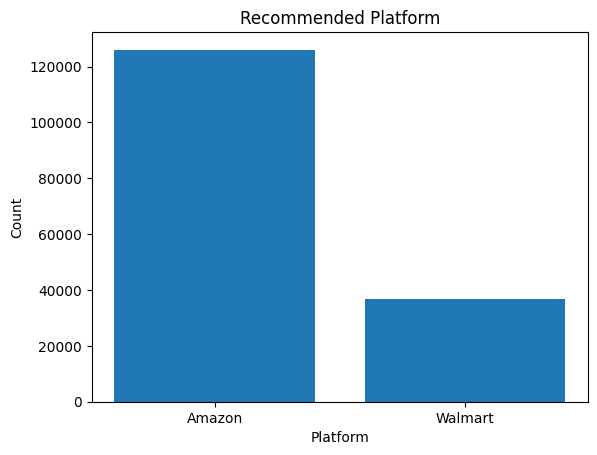

In [13]:
# Getting the count of recommended platforms after our rule-based approach
platform_count = merged_df['recommended_platform'].value_counts()

# Plotting the bar chart
fig, ax = plt.subplots()
ax.bar(platform_count.index, platform_count.values)
ax.set_title('Recommended Platform')
ax.set_xlabel('Platform')
ax.set_ylabel('Count')
plt.show()